In [219]:
import pandas as pd
import numpy as np

In [220]:
# matplotlib rebuild

import matplotlib.pyplot as plt
from matplotlib import font_manager

font_fname = 'C:/Windows/Fonts/nanummyeongjo.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000


# Load lv1

토큰화한 텍스트를 불러오는데 2020년에 사업보고서가 나온 기업(rcp_dt = 2020..)이 존재하여 제거해주었다.

In [241]:
df_price = pd.read_csv("./data/kospi/preprocessed/df_kospi200_adjusted_price.csv",index_col=0)
df_return = pd.read_csv('./data/kospi/preprocessed/df_kospi200_price_return.csv',index_col=0,low_memory=False)
df = pd.read_csv("./data/preprocessing/preprocessed/df_cosine.csv.",index_col=0)

df = df.drop('str_nouns', axis=1)
df = df.drop([417,1797,2055],axis=0) #얘네 3개는 rpt_nm 2020인 기업들

df.rcp_dt = [int(x) for x in df.rcp_dt]  #dataframe index 수정

# Filter the dataset
- There are several types of report such as restatement and first published version
- For simplifying the task, I'm going to use '사업보고서' only.  

In [243]:
naive_df = df.copy()
# naive_df = df[df.rpt_nm.map(lambda x : x.split(" ")[0]) == '사업보고서']
# naive_df.sort_values("연도",inplace=True)

# Set lv2

In [244]:
def length_adjust(str_) : 
    return (2-len(str_)) * '0' + str_

def date_convertor(date) : 
    year = length_adjust(str(date.year))
    month = length_adjust(str(date.month))
    day = length_adjust(str(date.day))
    yyyymmdd = int(year+month+day)
    return yyyymmdd

In [245]:
df_return.index

Int64Index([20100104, 20100105, 20100106, 20100107, 20100108, 20100111,
            20100112, 20100113, 20100114, 20100115,
            ...
            20191216, 20191217, 20191218, 20191219, 20191220, 20191223,
            20191224, 20191226, 20191227, 20191230],
           dtype='int64', length=2466)

In [246]:
lv2_index = df_return.index
lv2_index = [int(x) for x in df_return.index]

In [247]:
# lv2_index = pd.date_range(start='20100101', end='20191231')
# lv2_index = list(map(date_convertor,lv2_index))
lv2_columns = df_return.columns

lv2_df = \
pd.DataFrame(np.full(shape=(len(lv2_index),len(lv2_columns)),fill_value=np.nan),index=lv2_index,columns=lv2_columns)

In [248]:
lv2_df.shape
# (date_list,company_list)

(2466, 311)

# Generate the lv2

In [258]:
%%time
company_list = naive_df.crp_nm.unique()
for process,corp_name in enumerate(company_list) : 
    print("Process : {} | Total : {}".format(process+1,len(company_list)),end='\r')
    # slicing the dataset by corp_name
    tmp_df = naive_df[naive_df.crp_nm == corp_name]
    
    # set-up the time range 
    min_yr = tmp_df['연도'].min()
    max_yr = tmp_df['연도'].max()
    
    # container for saving the value 
    # those lists should be refreshed every loop.
    sim_ls = []; year_ls = []
    
    for yr in range(min_yr,max_yr) : 
        pre_df = tmp_df[tmp_df['연도'] == yr]
        next_df = tmp_df[tmp_df['연도'] == yr+1]
        publish_date = tmp_df[tmp_df['연도'] == yr+1]['rcp_dt']
        if len(pre_df) == 0 or len(next_df) == 0:
            continue
            # we don't have data
            # for example, we have 2014 but don't 2015.
            # therfore we can't measure similarity between 2014,2015.
            # so the value in lv2 at 2015 should be nan
            
        else : 
            pre_token = pre_df.str_tokens.map(lambda x : x.split(" ")).values
            next_token = next_df.str_tokens.map(lambda x : x.split(" ")).values   
            if type(pre_token[0]) == list and type(next_token[0]) == list :
                sim = len(set(next_token[0])&set(pre_token[0]))/len(set(next_token[0]))
            else : 
                 sim = len(set(next_token)&set(pre_token))/len(set(next_token))
        year_ls.append(publish_date.values[0])
        sim_ls.append(sim)
        
    assert len(year_ls) == len(sim_ls)
    lv2_df.loc[year_ls,corp_name] = sim_ls    

Wall time: 5.68 sotal : 275


In [114]:
# lv2_df.to_csv('./data/preprocessing/preprocessed/lv2_df.csv')

# Check the lv2
- if we apply mean operation through time, we can take overall auto-regressive similarity per company.

lv2 데이터의 index는 2010-2019년의 daily trading day, columns는 크롤링된 해당 기간에 편입되었던 기업들이다.

사업보고서 발행날짜인 rcp_dt를 저장하여 사업보고서가 발행된 날짜(기재정정이 있을 경우는 정정날짜)와 해당 기업의 auto-regressive similarity를 저장하였다. 이를 평균내서 10년동안의 사업보고서의 유사도의 변화를 수치화 할 수 있었으며 이를 통해 유의미한 결과를 도출해 보고자 하였다.

In [259]:
lv2_df.head()

,동화약품,우리은행,경방,삼양홀딩스,하이트진로,유한양행,CJ대한통운,하이트진로홀딩스,두산,대림산업,...,아진카인텍,한국전력공사,케이티,케이티앤지,티비에이치글로벌,기아자동차,삼성화재해상보험,쌍용양회공업,케이비증권,현대엘리베이터
20100104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


해당 기간 내의 기업들의 유사도를 평균내어 데이터프레임으로 저장하였고 이를 기반으로 유사도가 낮은 기업과 높은 기업들을 clustering하여 사업보고서 발간 날짜 이후 일정 기간동안의 누적수익률을 비교해보려고 한다. 

유사도들의 평균값은 0.74이고 제일 낮은 기업은 0.47, 높은 기업은 '코스맥스'로 1의 값이였는데 사업보고서 확인 결과 개요를 제외한 부분이 재무제표 table이라 제외된 결과 이러한 값이 나온것 같다. 일단은 내용상의 변화가 적은 것으로 해석하겠다.

In [260]:
filing_df = lv2_df.copy()

In [261]:
df_sim_mean = pd.DataFrame(lv2_df.mean().sort_values(ascending=False),columns={'평균유사도'})
df_sim_mean = df_sim_mean.dropna()
df_sim_mean.describe()

,평균유사도
count,271.000000
mean,0.742485
std,0.086552
min,0.475263
25%,0.690511
50%,0.746172
75%,0.795979
max,1.000000


In [262]:
df_sim_mean.head(10)

,평균유사도
코스맥스,1.000000
애경산업,0.994475
디와이,0.955789
세종공업,0.937490
오리온,0.928070
GKL,0.925793
디티알오토모티브,0.918303
한샘,0.915647
휠라홀딩스,0.908435
만도,0.903340


In [263]:
df_sim_mean.tail(10)

,평균유사도
SK케미칼,0.573209
현대그린푸드,0.567742
포스코플랜텍,0.566621
일동홀딩스,0.559503
코오롱,0.546697
알바이오,0.543312
대우조선해양,0.542492
한독,0.518269
케이피케미칼,0.514134
고려제강,0.475263


In [264]:
def cumprod_return(name,period):
    
    dic_index = {idx:i for i,idx in enumerate(df_price.index)}
    dic_column = {idx:i for i,idx in enumerate(df_price.columns)}
    
    
    rcp_ls = [x for x in df[df.crp_nm == name].rcp_dt]
    rcp_ls.sort(reverse=False)
    
    k = [(df_price.iloc[dic_index.get(i):dic_index.get(i)+period , dic_column.get(name)]/
         df_price.iloc[dic_index.get(i),dic_column.get(name)]-1)*100 for i in rcp_ls]
    df_comprod = (pd.concat([j[period-1:] for j in k],ignore_index=False)).to_frame()
    
    return df_comprod

In [265]:
def compare(corp1,corp2,corp3,corp4,period):
    
    a1 = cumprod_return(corp1,period)
    a2 = cumprod_return(corp2,period)
    a3 = cumprod_return(corp3,period)
    a4 = cumprod_return(corp4,period)
    

    fig = plt.figure()
    
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(a1, label=corp1)
    plt.legend(loc='upper left')
    
    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(a2, label=corp2)
    plt.legend(loc='upper left')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.plot(a3, label=corp3)
    plt.legend(loc='upper left')
    
    ax4 = fig.add_subplot(2,2,4)
    ax4.plot(a4, label=corp4)
    plt.legend(loc='upper left')
    
    return plt.show()

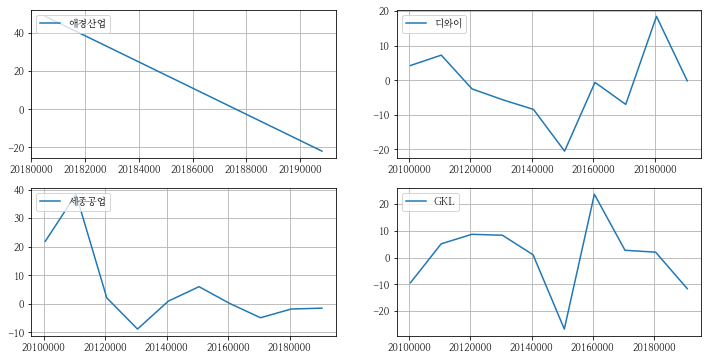

In [266]:
compare('애경산업','디와이','세종공업','GKL',30) #유사도 상위4기업

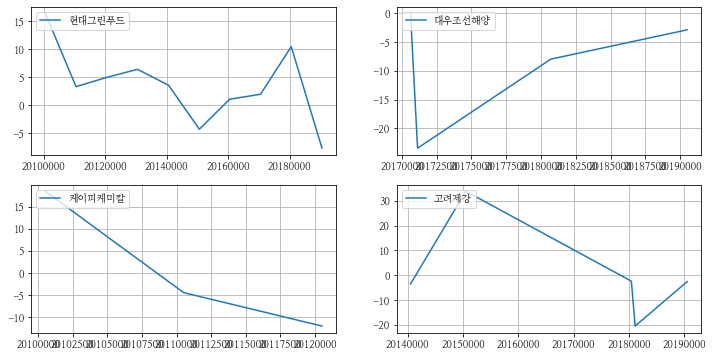

In [267]:
compare('현대그린푸드','대우조선해양','케이피케미칼','고려제강',30) #유사도 하위4기업

다른 식의 접근이 필요

In [268]:
df_demean.head()

,동화약품,우리은행,경방,삼양홀딩스,하이트진로,유한양행,CJ대한통운,하이트진로홀딩스,두산,대림산업,...,이노션,두산밥캣,넷마블,현대중공업지주,오리온,BGF리테일,SK케미칼,HDC현대산업개발,효성중공업,우리금융지주
20100104,-0.012799,NaN,0.010676,-0.000392,-0.001114,-0.016112,-0.043684,-0.006613,-0.031093,0.020357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100105,0.000307,NaN,0.006797,-0.002622,0.009225,0.008649,0.001132,-0.019563,0.000811,-0.006412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100106,-0.026298,NaN,0.020411,-0.014146,-0.032418,0.004994,0.030466,0.011432,0.048721,0.013820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100107,-0.016531,NaN,-0.001199,-0.013324,-0.037074,-0.005866,0.006063,-0.002709,0.030131,0.000197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100108,-0.003685,NaN,-0.022767,-0.010149,-0.026463,-0.016286,0.009822,0.011418,0.056828,0.002619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
lv2_df = pd.read_csv('./data/preprocessing/preprocessed/lv2_df.csv',index_col=0)

lv2_df = lv2_df.loc[df_demean.index]
lv2_df = lv2_df.loc[:,df_demean.columns]

val_idx,val_col = np.where(np.isfinite(lv2_df))

In [272]:
def get_after_filing_return(windows=30) : 
    container = np.full(shape=(len(val_idx),windows),fill_value=np.nan)
    idx_ls = []
    for num,(idx,col) in enumerate(zip(val_idx,val_col)) : 
        tmp = df_demean.iloc[idx:idx+windows,col].values
        if windows - len(tmp) > 0 : 
            tmp = np.array(tmp.tolist()+[np.nan]*(windows-len(tmp)))
        container[num] = tmp
        
        tmp_idx = df_demean.index[idx]
        tmp_col = df_demean.columns[col]        
        idx_ls.append("{}_{}".format(tmp_col,tmp_idx))
    
    final_df = pd.DataFrame(data=container,index=idx_ls)    
    return final_df

In [273]:
final_df = get_after_filing_return()
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
LF_20110324,0.000061,-0.016495,-0.008870,0.019928,-0.001140,-0.006487,0.007244,0.000619,-0.025652,0.003268,...,0.009653,-0.001946,-0.041322,0.002689,0.027474,0.006843,0.005947,0.026150,-0.012870,0.040474
조선내화_20110325,0.005443,0.009628,-0.006628,-0.004973,-0.011477,-0.006442,-0.001042,0.003772,0.007789,-0.006596,...,-0.003582,-0.008121,-0.009941,-0.000576,0.002377,0.007539,-0.035348,0.018673,0.018027,0.007321
S&T중공업_20110325,-0.030006,-0.049664,0.022391,-0.002461,0.034371,0.007290,-0.001042,-0.012981,0.002691,0.028774,...,-0.025138,0.056746,-0.025254,0.017692,0.006743,-0.002972,-0.026601,-0.006369,0.008126,0.022891
S&T모티브_20110325,0.013847,0.003119,-0.022875,-0.024615,0.026913,-0.011260,-0.007504,-0.015540,-0.006668,-0.029946,...,-0.001903,0.019544,-0.053725,-0.040085,-0.030615,0.015671,-0.032367,-0.017329,-0.013254,-0.010262
S&TC_20110325,0.013699,-0.023056,-0.008241,0.061521,-0.014699,-0.007276,0.020918,0.021124,-0.020905,-0.058657,...,-0.005840,-0.020493,-0.041848,0.039288,0.066932,-0.027643,0.001894,-0.020155,-0.052439,0.010815


In [274]:
sorted_df = final_df.cumsum(1)[30-1].reset_index().sort_values(30-1,ascending=False)
sorted_df.dropna(inplace=True)

sorted_df.describe()

,29
count,1913.000000
mean,0.002418
std,0.138243
min,-0.879879
25%,-0.076041
50%,-0.011198
75%,0.061666
max,1.177255


In [275]:
sim_ls = []
for i in sorted_df['index'] : 
    ii,di = i.split("_")
    di = int(di)
    
    tmp = lv2_df.loc[di,ii]
    sim_ls.append(tmp)
    
sorted_df['sim'] = sim_ls
sorted_df.columns = ['index','수익률','sim']

In [276]:
np.nanmean(lv2_df) #전체 기업들의 유사도 평균값

0.7448997870941031

In [277]:
sorted_df['demean_sim'] = sorted_df[['수익률','sim']].sim - (np.nanmean(lv2_df)) #기업유사도값에서 평균값을 뺀 columns 생성

In [278]:
sorted_df.head(10)

,index,수익률,sim,demean_sim
1602,한일현대시멘트_20180402,1.177255,0.487685,-0.257215
1092,영진약품_20160330,1.140725,0.853333,0.108434
1544,현대로템_20180330,0.982748,0.853503,0.108603
1119,한일현대시멘트_20160330,0.895831,0.916667,0.171767
849,JW중외제약_20150331,0.846516,0.862275,0.117376
1434,STX엔진_20170331,0.722945,0.867684,0.122785
1349,크라운해태홀딩스_20170331,0.624897,0.780255,0.035355
115,현대위아_20110331,0.613261,0.664234,-0.080666
1084,제일파마홀딩스_20160330,0.603437,0.879581,0.134681
187,일양약품_20110629,0.587352,0.531722,-0.213178


In [279]:
sorted_df.tail(10)

,index,수익률,sim,demean_sim
887,삼성전기_20150331,-0.346727,0.529148,-0.215752
1515,카프로_20180330,-0.352388,0.572414,-0.172486
1780,코오롱_20190401,-0.372058,0.745856,0.000957
514,현대상선_20130401,-0.383938,0.498507,-0.246392
609,KC그린홀딩스_20140327,-0.384055,0.995833,0.250934
548,STX중공업_20130401,-0.387178,0.603960,-0.140939
422,GS건설_20130329,-0.507145,0.703704,-0.041196
549,에이블씨엔씨_20130401,-0.538593,0.931579,0.186679
773,동부제철_20140515,-0.613420,0.747508,0.002609
921,포스코플랜텍_20150331,-0.879879,0.479899,-0.265000


In [286]:
print("누적수익률 상위 10개 기업 :",sorted_df.head(10).demean_sim.mean())
print("누적수익률 하위 10개 기업 :" ,sorted_df.tail(10).demean_sim.mean())

누적수익률 상위 10개 기업 : 0.0247941530235207
누적수익률 하위 10개 기업 : -0.06405880959167351
